In [1]:
import os
import cv2
import numpy as np
from matplotlib import pylab as plt
#from matplotlib import colors as mc

#from PIL import Image
from astropy.io import fits
#from astropy.wcs import WCS
#from astropy import units as u
from sunpy.map import Map
#from sunpy.coordinates import frames

/home/szao/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


parameters: [image cut level, gradientcut level, smooth scale]

6420: [0.6, 0.4, 40];

2048: [0.6, 0.4, 40]

Channels: $\mathrm{H}\alpha$, $\mathrm{Ca}K$, White Light

In [2]:
CHANNEL = ['Ha', 'HA', 'ha', 656.28]# H\alpha
#CHANNEL = ['CaK', 'CAK', 'cak', 393.73]# CaK
#CHANNEL = ['WL', 'WL', 'wl', 'White Light']# White Light
#notation = r'SZAO H$\alpha$'

yyyy = 2025# year
date = f'{yyyy}0825{CHANNEL[1]}'#### ONLY change date

local_path = '/home/szao/solar_data/pro/'
save_matrix_name = os.path.join(local_path, 'alignment/Rotation Matrix', f'{yyyy}0816{CHANNEL[1]} rotation matrix.txt')#### saved at local directory and change ~MONTHLY

path = f'/run/user/1000/gvfs/smb-share:server=szaocloud.local,share=solar_observation/{yyyy}/{CHANNEL[2]}/'
directory = os.path.join(path, date)
save_directory = os.path.join(directory, date)
''''''
# load data
fits_files = os.listdir(directory)
file_list = []
for file in fits_files:
    if (('Sun' in file) and ('.fits' in file)):
        file_list.append(os.path.join(directory, file))
#print(len(file_list))
hdrloc_obs = 0
#hdrloc_gong = 1

image_cut_level = 0.5# threshold of luminosity check
grad_cut_level = 0.4# threshold of gradient check
smooth_scale = 40# smooth image

gong_file = os.path.join(local_path, 'alignment/Reference GONG Maps', '20250816012742Lh.fits.fz')
gong_map = Map(gong_file)

length = 10
origin = 'lower'
dpi = 300
image_extention = 'jpg'# save image extention
plt.rcParams.update({
    'font.family': 'serif',# General font family
    'font.serif': 'Times New Roman',# Specific serif font
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',# Roman (serif) font for math
    'mathtext.it': 'Times New Roman:italic',# Italic
    'figure.dpi': dpi,
    #'legend.fontsize': legend_size,
    'grid.alpha': 0.3,
    'savefig.transparent': True
})


Read fits file, construct UTC string and normalize image

In [3]:
def read_fits_file(filename):
    hdul = fits.open(filename)
    hdul.info()
    return hdul

def check_image_size(input_image):
    """
    In .fits file, Ny=image.shape[0] and Nx=image.shape[1]
    """
    Ny, Nx = input_image.shape
    return Ny, Nx, np.min([Ny, Nx])

from skimage.exposure import rescale_intensity
def normalize_image(input_image, out_range=(0,255)):
    image_norm = rescale_intensity(input_image, in_range='image', out_range=out_range).astype(np.uint8)
    return image_norm

>Detect disk center and radius

Least Square

detect and strengthen limbs first

In [4]:
from scipy.ndimage import median_filter, uniform_filter
from skimage.filters import sobel
def find_limbs(input_image, image_cut_level=0.6, grad_cut_level=0.4, smooth_scale=40):
    # 6240, image cutlevel=0.6, grad cutlevel=0.4; 2048, image cutlevel=0.6, grad cutlevel=0.4
    # prepare coordinate grid
    Ny, Nx, _ = check_image_size(input_image)# (Ny, Nx)
    x = np.tile(np.arange(Nx), (Ny, 1))
    y = np.tile(np.arange(Ny).reshape(-1, 1), (1, Nx))
    # margin mask: remove edges
    margin = 30
    mask = (x >= margin) & (x <= Nx - margin) & (y >= margin) & (y <= Ny - margin)   
    input_image *= mask

    median_filtered = median_filter(input_image, size=3)# smooth image with median filter
    gradient = sobel(median_filtered)# edge detection
    gradient_threshold = grad_cut_level * np.max(gradient)
    std_sob = np.std(gradient[gradient > gradient_threshold])# compute robust threshold using std-dev of strong edges

    strong_edge = np.copy(gradient)
    strong_edge[gradient <= gradient_threshold] = -1# find strong edges (value): SZ (6420) 0.01, SZ (2048) 800, GONG 0.005. If not strong enough, mask by minus value
    if (strong_edge.size==0):
        raise ValueError("No strong edges detected.")

    # smooth original image to suppress center
    smooth_scale = 40# SZ
    #smooth_scale = 20
    image_smooth = uniform_filter(input_image.astype(np.float32), size=smooth_scale)
    image_threshold = image_cut_level * np.max(image_smooth)

    sa = (strong_edge > 3 * std_sob) & (input_image < image_threshold)#### final mask for candidate limb points (6420 use or, 2048 use and)
    y_limb, x_limb = np.where(sa)
    limb_points = np.column_stack([y_limb, x_limb])

    if (limb_points.shape[0] < 10):
        raise ValueError("Too few limb points")

    return limb_points, y_limb, x_limb

`numpy` rough + `scipy` refine

In [5]:
from scipy.optimize import least_squares
def fit_circle_algebraic(x, y):
    """
    Fit circle using algebraic least squares (linear) by numpy.
    Returns initial guess (x_center, y_center, radius).
    """
    A = np.column_stack((2*x, 2*y, np.ones_like(x)))
    b = x**2 + y**2
    p, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    xc, yc, c = p
    r = np.sqrt(xc**2 + yc**2 + c)
    return xc, yc, r

def scipy_leastsq_circle(input_image, image_cut_level=0.6, grad_cut_level=0.4, smooth_scale=40):
    """
    Nonlinear least-squares fit to a circle.
    Parameters:
        x, y: coordinates of limb points
    Returns:
        xc, yc: center coordinates
        r: radius
    """

    def residuals(params, x, y):
        xcenter, ycenter, r = params
        return np.sqrt((x - xcenter)**2 + (y - ycenter)**2) - r

    _, y_limb, x_limb = find_limbs(input_image, image_cut_level=image_cut_level, grad_cut_level=grad_cut_level, smooth_scale=smooth_scale)
    initial_guess = fit_circle_algebraic(x_limb, y_limb)# initial: use numpy algebraic least squares (linear) fitting
    print(f"Algebraic guess: xc={initial_guess[0]:.4f}, yc={initial_guess[1]:.4f}, r={initial_guess[2]:.4f}")

    refined_fit = least_squares(residuals, initial_guess, args=(x_limb, y_limb))
    xcenter, ycenter, radius = refined_fit.x
    print(f"Refined fit: xc={xcenter:.4f}, yc={ycenter:.4f}, r={radius:.4f}")
    return (xcenter, ycenter), radius

>Shift disk

In [6]:
def shift_disk(input_image, xcenter, ycenter):
    Ny, Nx, image_size = check_image_size(input_image)# (Ny, Nx) or (height, width)
    #print(Ny, Nx)
    # (dx, dy): from disk center to image center, x for width and y for height
    delta_y = (Ny / 2)  - ycenter
    delta_x = (Nx / 2)  - xcenter
    shift_matrix = np.array([[1, 0, delta_x], 
                             [0, 1, delta_y]], dtype=np.float32)
    shift_image = cv2.warpAffine(input_image, shift_matrix, (Nx,Ny))# shift
    output_image = cv2.resize(shift_image.T, dsize=(image_size,image_size))# transpose
    return output_image, shift_matrix, image_size

>Affine transform

\begin{equation*}
\mathbf{M} = 
\begin{bmatrix}
    a & b & t_{x}\\
    c & d & t_{y}
\end{bmatrix}
\end{equation*}

$a$, $d$: scaling + rotation; $b$, $c$: shearing + rotation; $t_{x}$, $t_{y}$: translation

\begin{equation*}
\begin{bmatrix}
    x'\\
    y'
\end{bmatrix} = 
\begin{bmatrix}
    a & b\\
    c & d
\end{bmatrix} \cdot
\begin{bmatrix}
    x\\
    y
\end{bmatrix} + 
\begin{bmatrix}
    t_{x}\\
    t_{y}
\end{bmatrix}
\end{equation*}

for a given center, scale $k$ and rotation angle $\theta$, OpenCV uses $\alpha = k\cos{\theta}$ and $\beta = k\sin{\theta}$, so 
\begin{equation*}
\mathbf{M} = 
\begin{bmatrix}
    \alpha & \beta & (1 - \alpha)x_{\mathrm{c}} - \beta y_{\mathrm{c}}\\
    -\beta & \alpha & \beta x_{\mathrm{c}} + (1 - \alpha)y_{\mathrm{c}}
\end{bmatrix}
\end{equation*}

for only translation, 
\begin{equation*}
\mathbf{M} = 
\begin{bmatrix}
    1 & 0 & t_{x}\\
    0 & 1 & t_{y}
\end{bmatrix}
\end{equation*}

In [7]:
def estimate_affine_transform(test_image, reference_image, max_features=100, min_keypoints=10):
    """
    Estimates affine transform (rotation + translation) from test_image to reference_image.
    Returns transformation matrix M (2x3).
    """
    test_norm = normalize_image(test_image)
    reference_norm = normalize_image(reference_image)

    # ORB feature detection, description and check. low variance: threshold=20000
    orb = cv2.ORB_create(nfeatures=max_features)
    keypoints1, descriptors1 = orb.detectAndCompute(test_norm, None)
    #print(len(keypoints1))
    if ((descriptors1 is None) or (len(keypoints1) < min_keypoints)):
        raise ValueError("Feature detection failed on the test image.")

    keypoints2, descriptors2 = orb.detectAndCompute(reference_norm, None)
    #print(len(keypoints2))
    if ((descriptors2 is None) or (len(keypoints2) < min_keypoints)):
        raise ValueError("Feature detection failed on the reference image.")
    
    # match descriptors using brute force
    brute_force = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = brute_force.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)# Sort matches by distance (match quality)
    print(f'Good matches: {len(matches)}')
    if (len(matches) < 3):
        raise ValueError("Not enough good matches found for alignment.")

    # use good matches to estimate affine transform
    src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    Matrix_estimate, mask = cv2.estimateAffinePartial2D(src_points, dst_points)
    #print(Matrix_estimate)
    angle_rad = -1 * np.arctan2(Matrix_estimate[1, 0], Matrix_estimate[0, 0])# only extract rotation angle
    angle_deg = np.rad2deg(angle_rad)

    # create rotation matrix (center given and fixed)
    height, width = test_image.shape
    center_fixed = (width // 2, height // 2)
    Matrix_rotation_only = cv2.getRotationMatrix2D(center_fixed, angle=angle_deg, scale=1.0)
    return Matrix_estimate, Matrix_rotation_only, angle_deg

>Align image and evaluate

In [8]:
from skimage.metrics import structural_similarity
def align_to_reference(max_features, input_image, reference_image, calculate_matrix=True, transform_matrix=None):
    height_i, width_i = input_image.shape
    height_r, width_r = reference_image.shape
    if calculate_matrix:# if matrix unknown
        transform_matrix_rotation_and_scale, transform_matrix_rotation, angle_deg = estimate_affine_transform(input_image, reference_image, max_features=max_features)
        #print(transform_matrix_rotation_and_scale)
        #print(transform_matrix_rotation)
        aligned_image_output = cv2.warpAffine(input_image, transform_matrix_rotation, (width_i, height_i), flags=cv2.INTER_LINEAR)# transform for output
        aligned_image_evaluate = cv2.warpAffine(input_image, transform_matrix_rotation_and_scale, (width_r, height_r), flags=cv2.INTER_LINEAR)# transform for evaluate
        score = structural_similarity(normalize_image(aligned_image_evaluate), normalize_image(reference_image))# ssim, evaluate similarity
        print(f'Alignment SSIM Score: {score:.4f}')
    else:# if already obtained matrix
        transform_matrix_rotation = np.copy(transform_matrix)
        aligned_image_output = cv2.warpAffine(input_image, transform_matrix_rotation, (width_i, height_i), flags=cv2.INTER_LINEAR)# transform for output
        #aligned_image_evaluate = cv2.resize(aligned_image_output, dsize=reference_image.shape)
        angle_deg = None
        score = 'Already scored.'
    return aligned_image_output, transform_matrix_rotation, angle_deg, score

>Fit rotation matrix

Fit the transform matrix `monthly`

rotation matrix is saved as:
\begin{equation*}
\begin{bmatrix}
\alpha\\
\beta\\
t_{x}\\
t_{y}\\
\theta
\end{bmatrix}
\end{equation*}

In [9]:
fit_matrix_file = os.path.join(local_path, 'alignment/Reference GONG Maps', '2025-08-16-0127_1-Sun_00013.fits')
observation_file_name = os.path.abspath(fit_matrix_file)
hdul = read_fits_file(observation_file_name)
data_obs, header_obs = hdul[hdrloc_obs].data, hdul[hdrloc_obs].header# array shape: (ny, nx), while in fits is (nx, ny)
_, _, image_size = check_image_size(data_obs)
fit_image = data_obs[:image_size, :image_size]# cut a square image (avoid leaving off the last pixel)
hdul.close()# free memory

(xc_obs, yc_obs), r0_obs = scipy_leastsq_circle(fit_image, image_cut_level=image_cut_level, grad_cut_level=grad_cut_level, smooth_scale=smooth_scale)
image_shift, shift_matrix, _ = shift_disk(fit_image, xcenter=xc_obs, ycenter=yc_obs)
aligned_image, MATRIX, angle_degree, score = align_to_reference(max_features=100, input_image=image_shift, reference_image=gong_map.data, 
                                      calculate_matrix=True, transform_matrix=None)

alpha, beta = MATRIX[0, 0:2]
tx, ty = MATRIX[0:2, 2]
components = [alpha, beta, tx, ty, angle_degree]

with open(save_matrix_name, 'w') as save_matrix:# Open a file in write mode ("w" overwrites, "a" appends)
    for item in components:
        save_matrix.write(f'{item}\n')
save_matrix.close()

print(MATRIX)
print(f'Rotation matrix saved to: {save_matrix_name}.')

Filename: /home/szao/solar_data/pro/alignment/Reference GONG Maps/2025-08-16-0127_1-Sun_00013.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (6420, 6422)   int16 (rescales to uint16)   
Algebraic guess: xc=3206.4789, yc=3254.4539, r=2465.6925
Refined fit: xc=3206.4461, yc=3254.5025, r=2465.6585
Good matches: 10
Alignment SSIM Score: 0.6598
[[-2.73651621e-01  9.61828878e-01  1.00095101e+03]
 [-9.61828878e-01 -2.73651621e-01  7.17589240e+03]]
Rotation matrix saved to: /home/szao/solar_data/pro/alignment/Rotation Matrix/20250816HA rotation matrix.txt.


/tmp/ipykernel_40859/196200624.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New

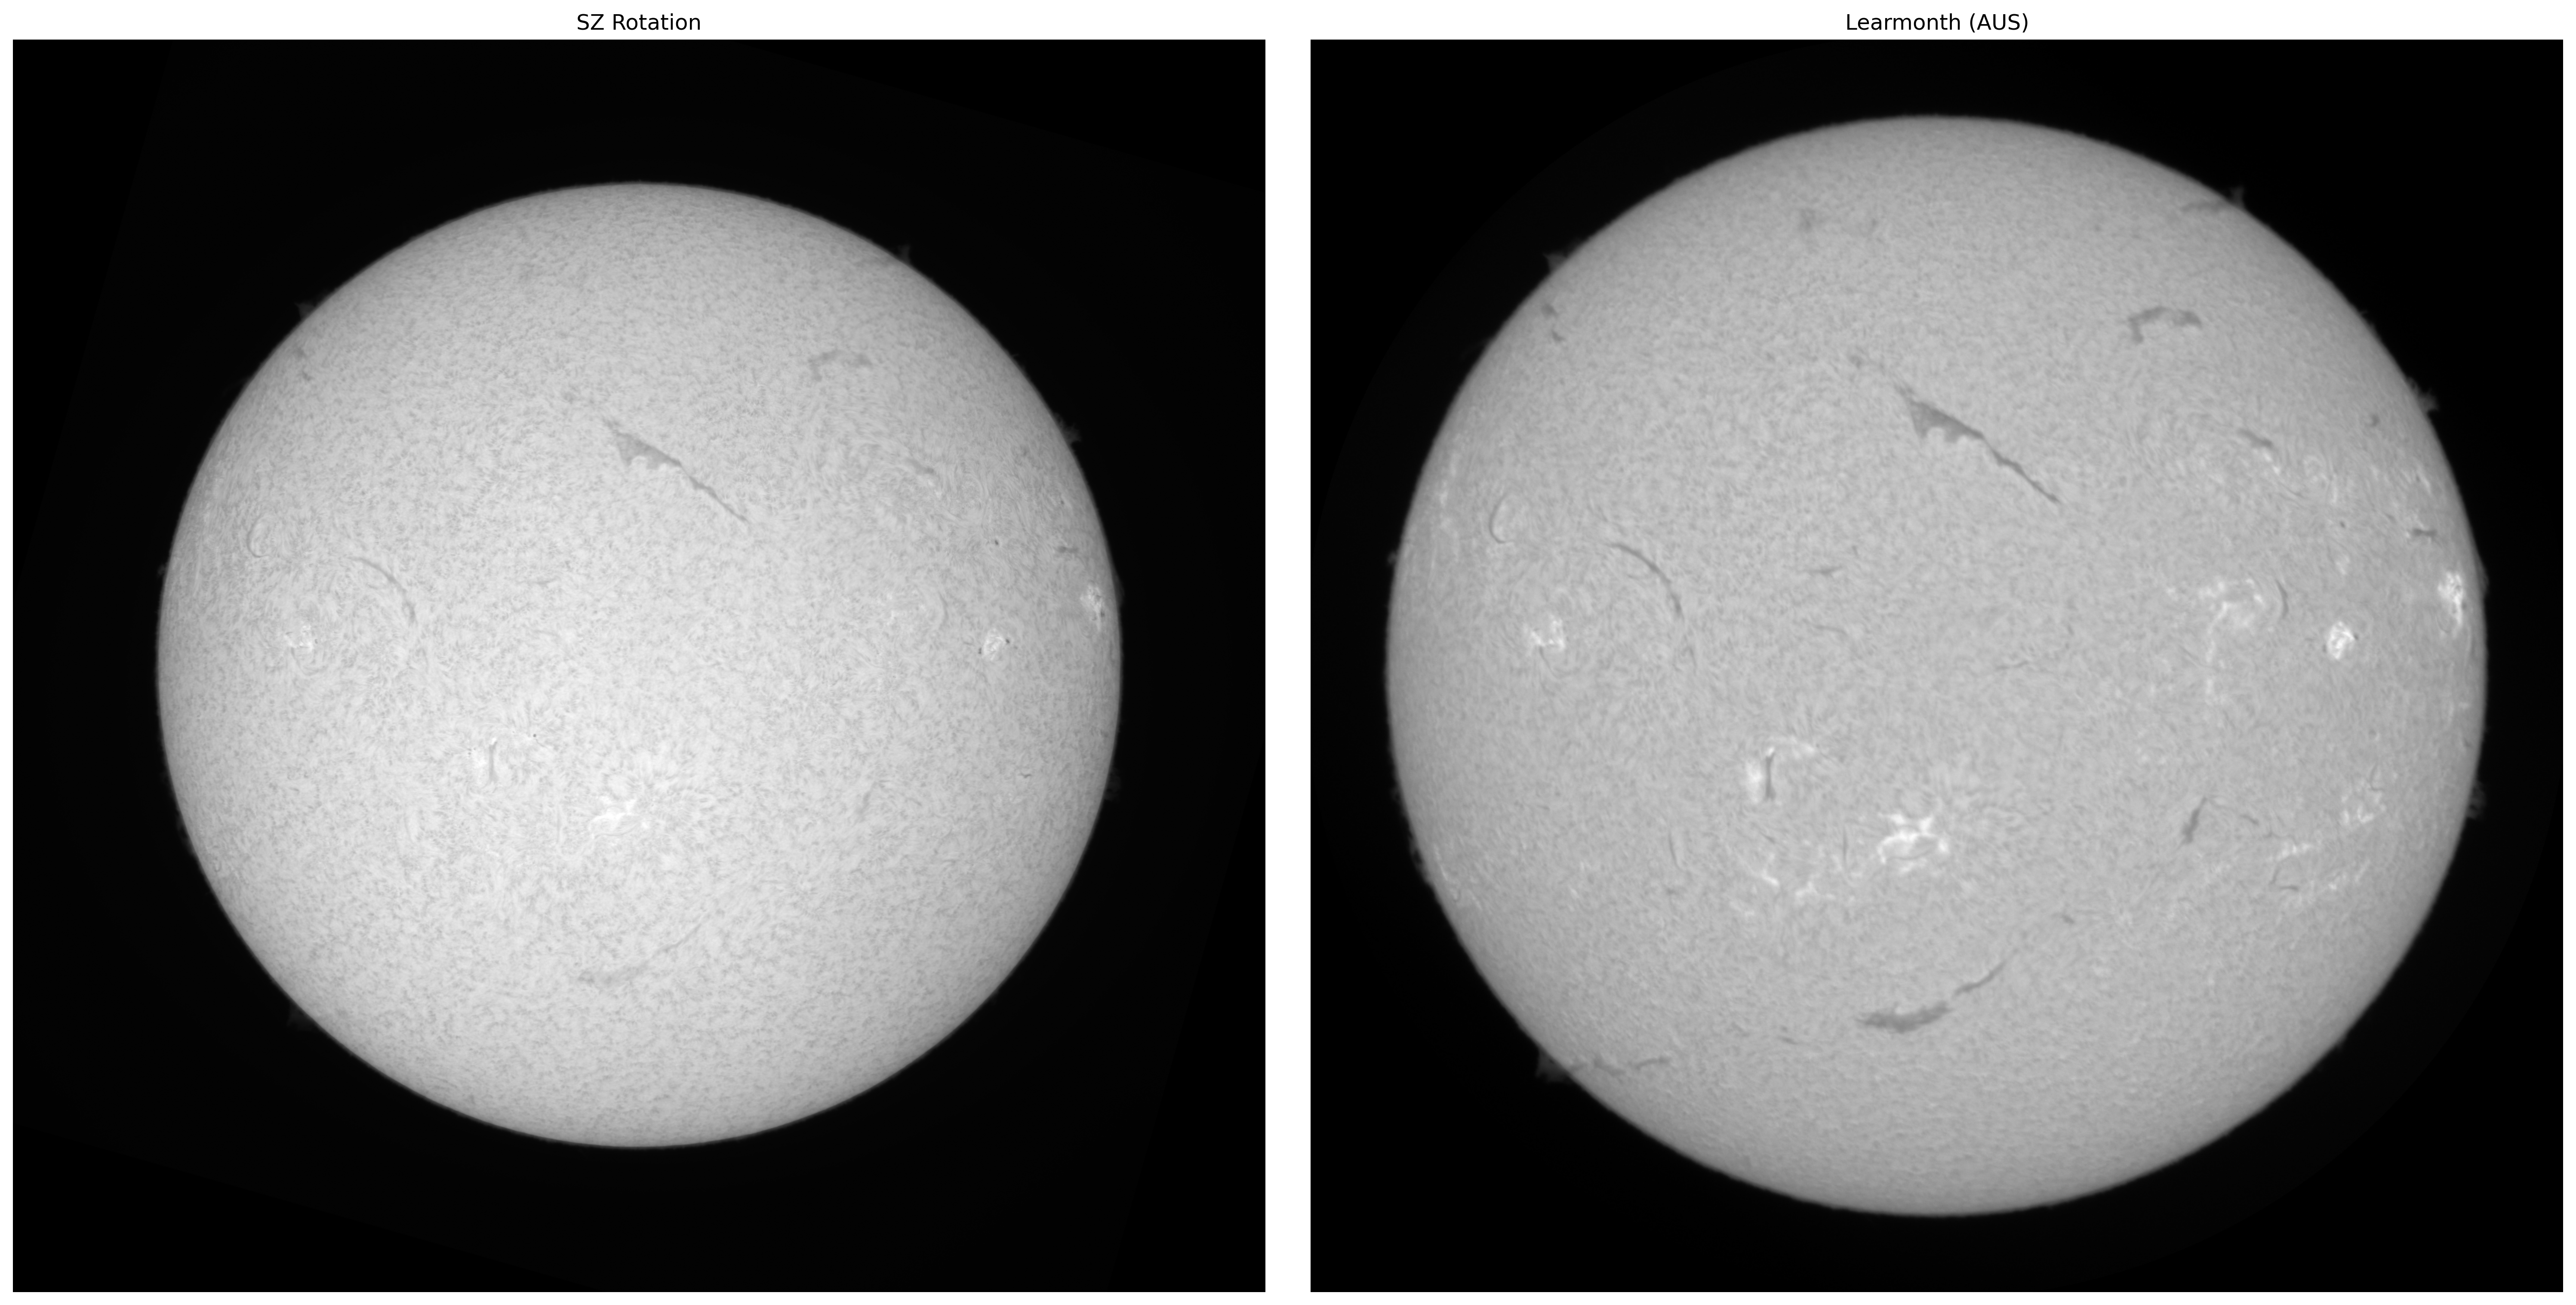

In [10]:
figure, ax = plt.subplots(1, 2, figsize=(2*length,length), layout='constrained')
sunplot = ax[0].imshow(aligned_image, origin=origin, cmap='grey')# aligned
ax[0].axis('off')
ax[0].set_title('SZ Rotation', fontsize=12)

gong = ax[1].imshow(gong_map.data, origin=origin, cmap='grey')# aligned
ax[1].axis('off')
ax[1].set_title('Learmonth (AUS)', fontsize=12)
figure.show()